<a href="https://colab.research.google.com/github/shmokhsidi79-design/week4labs/blob/main/WeeklyProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weekly Project: Image Classification with Transfer Learning

In this project, you will build a complete image classification pipeline using transfer learning. You'll work with the dataset provided by your instructor.

**Learning Objectives:**
- Load and prepare image datasets for deep learning
- Use pre-trained models for transfer learning
- Implement two transfer learning strategies: fine-tuning and feature extraction
- Evaluate model performance
- Deploy models using ONNX for production (Optional)

**References:**

- [Training with PyTorch](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html)
- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Table of Contents

1. [Data Ingestion](#1)
2. [Data Preparation](#2)
3. [Model Building](#3)
4. [Training](#4)
   - [4.1 ConvNet as Fixed Feature Extractor](#4-1)
   - [4.2 Fine-tuning the ConvNet](#4-2)
5. [Evaluation](#5)
6. [Inference on Custom Images](#6)
7. [Deployment (ONNX)](#7)

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
!pip install kaggle


In [3]:
%%writefile kaggle.json
{
  "username": "shu22011",
  "key": "KGAT_9d678d79c5a6bda2243465218956901e"
}

Writing kaggle.json


## Setup Device

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!pip install kaggle
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 88% 306M/346M [00:00<00:00, 816MB/s] 
100% 346M/346M [00:02<00:00, 146MB/s]


**Note: you will need a GPU; so please run this on Colab and specify a GPU runtime (e.g., T4-GPU)**

In [6]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


<a name='1'></a>
## 1. Data Ingestion

**Task**: The dataset should be downloaded and extracted to a local directory.

**References:**

- [Dataset and DataLoader](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#dataset-and-dataloader)
- [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)

In [7]:
!pip install kaggle
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:

!unzip -q /content/intel-image-classification.zip -d /content/intel_dataset


**Task**: create a `train_dataset` and `test_dataset` (without transforms for now).

In [9]:

import os
from torchvision.datasets import ImageFolder # نستورد ImageFolder لتحميل الصور مرتبة الكلاسات


# الباث حق الداتاسيت
train= "/content/intel_dataset/seg_train/seg_train"
test  = "/content/intel_dataset/seg_test/seg_test"

# نسوي داتاسيت بدون ترانسفورمز عشان نقرا الصور ونرتبها حسب الكلاسات
train_dataset = ImageFolder(root=train)
test_dataset  = ImageFolder(root=test)


print("Train exists:", os.path.exists(train), train) #السطرين عشان نتاكد انها موجوده ويطبع ترو لو كانت موجودة
print("Test exists :", os.path.exists(test), test)

Train exists: True /content/intel_dataset/seg_train/seg_train
Test exists : True /content/intel_dataset/seg_test/seg_test


**Quick Check**: verify the counts of both train and test sets, match what's in the original source (Kaggle).

In [10]:
# نتاكد من معلومات الداتاسيت
print("Number of training:", len(train_dataset)) #عدد الكلاسات اللي بنسوي لها ترايننق
print("Number of testing:", len(test_dataset))#عدد الكلاسات اللي بنسوي لها تسيتنق
print("Class names:", train_dataset.classes) # هنا بيطبع لنا اسماء الكلاسات ومن الافضل معرفتها عشان لو احتجنا نشتغل عليها

Number of training: 14034
Number of testing: 3000
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


<a name='2'></a>
## 2. Data Preparation

Before training, we need to:
1. Define augmentation for training
2. Define normalization for both training and testing
3. Create **`DataLoader`** for efficient batch processing

**Task:** Create transformation pipelines for training and validation. Pre-trained models expect ImageNet normalization statistics.

**Reference:**

- [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device) #نتاكد الجهاز يستخدم cpu or gpu


Using device: cuda


In [12]:
from torchvision import transforms
# torchvision = مكتبة خاصة بالـ PyTorch
# ممتازة للي بنحتاجه الحين (الصور)
# نستطيع استخدامها أيضًا بالفيديوز والموديلات الجاهزة


# أرقام نستخدمها عشان نعدل الألوان بالصور
mean = [0.485, 0.456, 0.406]
# ResNet سابقًا تدرب على مودل فيه ملايين الصور

std  = [0.229, 0.224, 0.225]
# ومن خلالها حسبوا قيم المتوسط والتشتت للألوان
# وذي القيم النتيجة عشان كذا يفضل استخدامها بدون التغيير فيها


# هنا استدعينا الترانسفورمز
data_transforms = {
    # هنا ديكشنري

    "train": transforms.Compose([
        # سوينا استدعاء فقط للقيم اللي بندرب عليها
        # الـ Compose مهم جدًا لأننا نبيه يمشي على العمليات بالترتيب

        transforms.RandomResizedCrop(224),
        # 224x224
        # قص وتغيير حجم بشكل عشوائي
        # عشان المودل يتعلم الفكرة العامة من الصورة بدون ما يحفظها

        transforms.RandomHorizontalFlip(),
        # قلب أفقي عشوائي
        # عشان يعلم المودل أكثر على الداتاسيت

        transforms.ToTensor(),
        # تحويل لـ Tensor
        # مهم جدًا عشان يحول الصورة إلى تينسور يفهمه PyTorch

        transforms.Normalize(mean, std),
        # هنا بيطبق معادلة
        # عشان يخلي الصورة بنفس التوزيع اللي تعلّم عليه ResNet
    ]),

    "val": transforms.Compose([
        # هنا نبي نقيس الأداء الحقيقي للموديل

        transforms.Resize(256),
        # يغير حجم الصورة بحيث يكون اصغر جزء حجمه 256 وبدون تشويه

        transforms.CenterCrop(224),
        # يقص 224 × 224 من وسط الصورة
        # لان الجزء المهم بالصورة بالعادة يكون بالنص وهو اللي نحتاجه

        transforms.ToTensor(),
        # تحويل لـ Tensor
        # مهم جدًا عشان يحول الصورة إلى تينسور يفهمه PyTorch

        transforms.Normalize(mean, std),
        # هنا بيطبق معادلة
        # عشان يخلي الصورة بنفس التوزيع اللي تعلّم عليه ResNet
    ]),
}


In [13]:
from torchvision.datasets import ImageFolder
#نستورد أداة جاهزة تقرأ الصور من المجلدات وترتبها تلقائيًا حسب الكلاسات من مكتبة torchvision
#imageFolder:
#تدخل على مجلد
#تشوف كل مجلد داخله
#تعتبر اسم المجلد هو اسم الكلاس
#تجمع الصور وتربطها بالليبل حقها

train,test #هنا باث البيانات اللي حفظته في المتغيرات ذي سويت له استدعاء

train_dataset = ImageFolder(root=train, transform=data_transforms["train"])
 #imagefolder بيدخل على مجلد التدريب
 #بيطبق عليه الدوال اللي عرفناه قبل من قص وقلب وتغيير
 #الاوتبوت حقه بيكون image, label

test_dataset  = ImageFolder(root=test,  transform=data_transforms["val"])
#imagefolder بيدخل على مجلد التدريب
#نبي نشوف الأداء الحقيقي

print("Train:", len(train_dataset)) #جمل طباعة
print("Test:", len(test_dataset)) #جمل طباعة
print("Classes:", train_dataset.classes) #جمل طباعة لاسماء الكلاسات

Train: 14034
Test: 3000
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [14]:
from torch.utils.data import DataLoader
#DataLoader هو المسؤول عن توصيل البيانات للمودل
#تقوم بتقسيم البيانات وترتبيها
#ترسلها للمودل batch batch
batch_size = 32
#عدد الصور اللي بتدخل المودل في نفس الوقت
#32 صورة
num_workers = 2
#عدد اللي يقرأون الصور بالتوازي
#in parallel
#بالعادة يكونون 2 او 4 بس جهازي مايناسبه الا 2

train_loader = DataLoader(
    train_dataset,
    #الداتاسيت اللي سويناه بـ ImageFolder
    #موجودة فيه فيه الصور + labels
    batch_size=batch_size,
    #كم صورة تدخل في كل خطوة تدريب
    shuffle=True,
    #مهم جددا لانه يمنع المودل من حفظ ترتيب الصور
    #عن طريق خلطها في كل epoch
    num_workers=num_workers,
    #يزيد السرعة
)

test_loader = DataLoader(
    test_dataset,
    #الداتاسيت اللي سويناه بـ ImageFolder
    #موجودة فيه فيه الصور + labels
    batch_size=batch_size,
     #كم صورة تدخل في كل خطوة تدريب
    shuffle=False,
    #عشان التقييم يكون عادل
    #والتيست يكون ثابت عندنا بدون لخبطة
    num_workers=num_workers,
     #يزيد السرعة
)


**Quick Check**: Visualize a batch of training images

In [15]:
import helper_utils

In [16]:
helper_utils.visualize_batch?

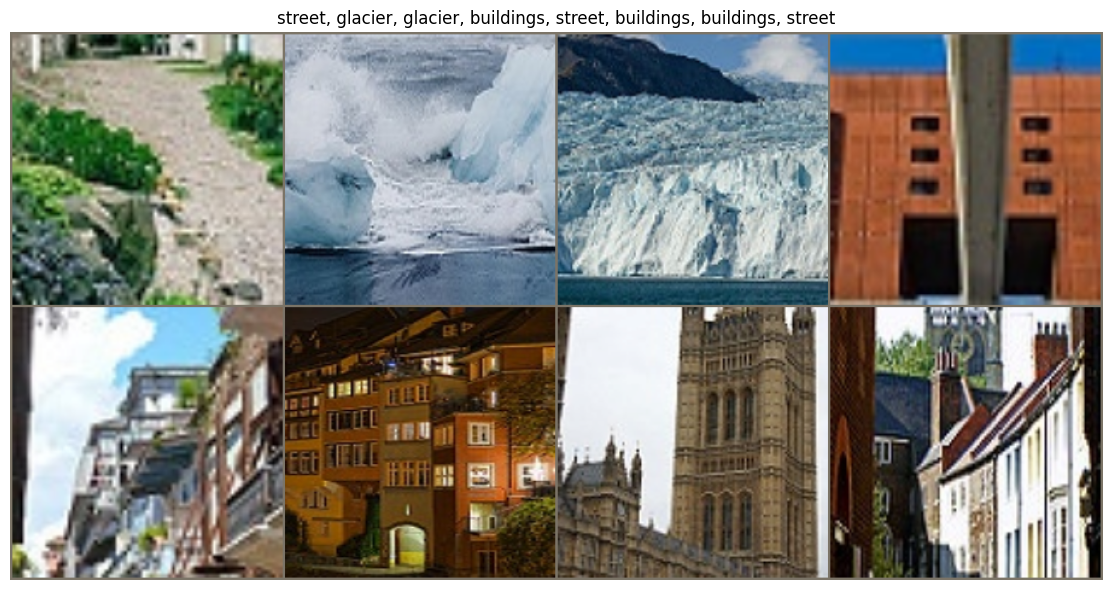

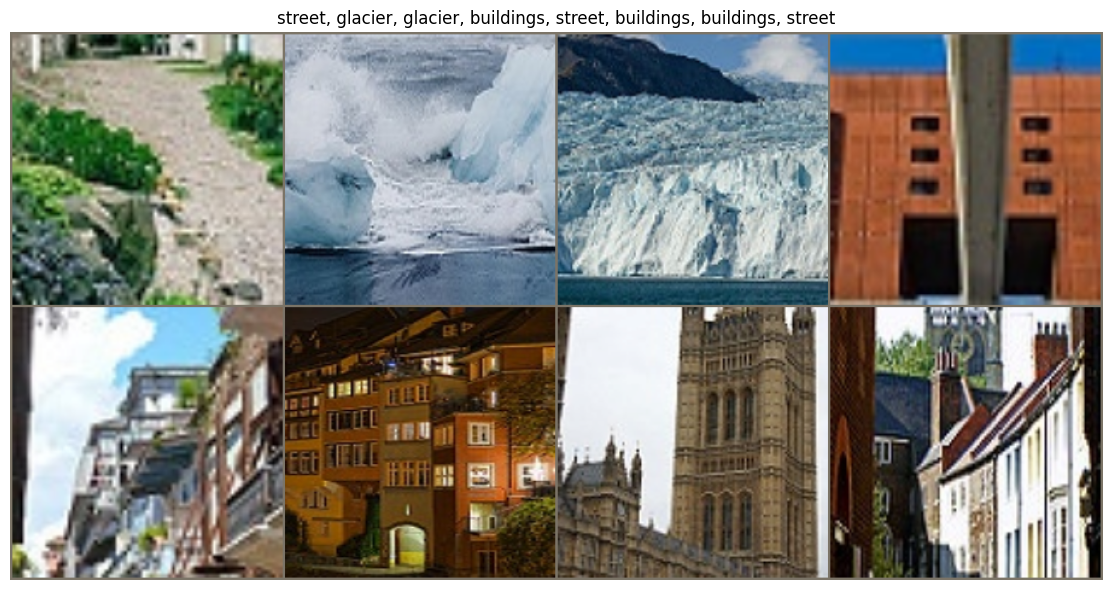

In [17]:
class_names = train_dataset.classes if hasattr(train_dataset, "classes") else train_full_for_train.classes
helper_utils.visualize_batch(train_loader, class_names)


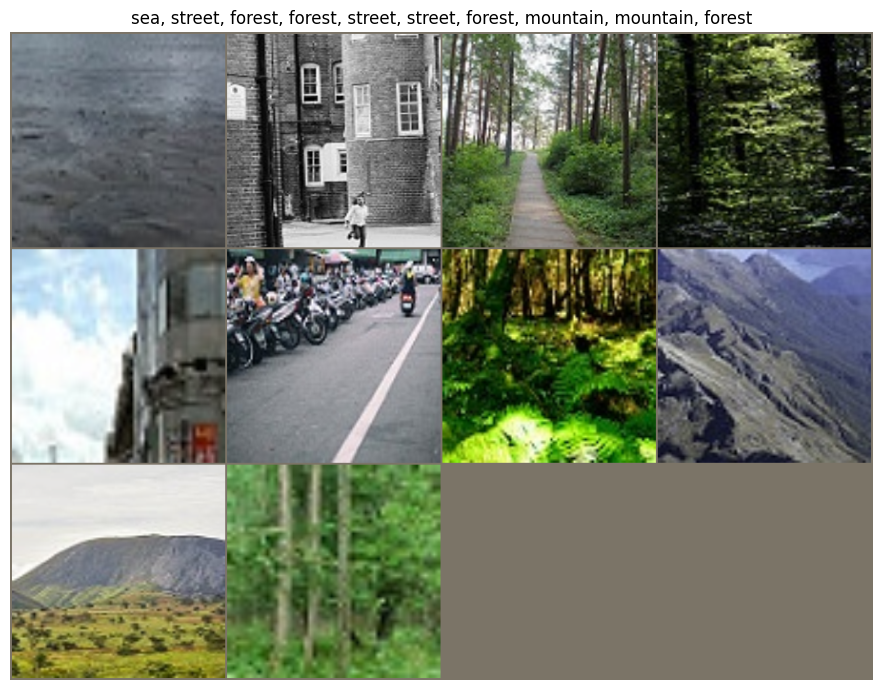

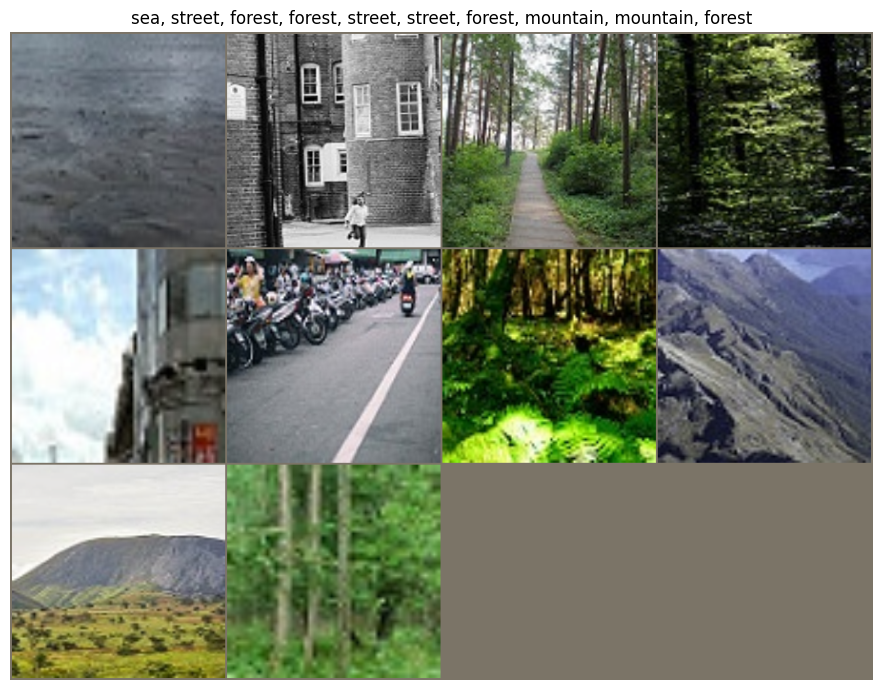

In [18]:
class1names = train_dataset.classes

helper_utils.visualize_batch(
    #نعرض صور الباتش من التدريب
    train_loader,
    class1names,
    num_images=10,
    figsize=(14, 7)
    #هنا بالسطرين ذي حددت عدد الصور وحجمها
)


<a name='3'></a>
## 3. Model Building

We'll use a pre-trained ResNet-18 model and adapt it for our 6-class classification task.

**Task:** Load a pre-trained ResNet-18 model and modify the final layer for 6 classes.

**Reference:**

- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [torchvision.models](https://pytorch.org/vision/stable/models.html)
- [ResNet documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html)

In [19]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #نتاكد اذا في GPU اذا مافي يستخدم الCPU
num_classes = 6 #عدد الكلاسات عندنا

weights = models.ResNet18_Weights.DEFAULT #يستخدم الاوزان الافتراضية للمودل ResNet18
model = models.resnet18(weights=weights) #ينشئ المودل ويجط فيه الاوزان اللي احنا انشئناها

model.fc = nn.Linear(model.fc.in_features, num_classes) #FC= FULLY CONNECTED ياخذ اخر طبقة من المودل اللي انشئناه
model = model.to(device) #يحطها بالDEVICE

print("device:", device) #جمل طباعة
print("fc layer:", model.fc)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


device: cuda
fc layer: Linear(in_features=512, out_features=6, bias=True)


<a name='4'></a>
## 4. Training

**Task:** Implement a training **function** and then train using two different transfer learning strategies.

**Reference:** [PyTorch Training Tutorial](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop)

In [20]:
import torch

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        preds = outputs.argmax(dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc


def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs=3):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
            f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}"
        )

    return history


In [21]:
from torch.utils.data import Subset, DataLoader
import torch

# 1) Dataset كامل (train + val)
train_full_for_train = ImageFolder(
    train,
    transform=data_transforms["train"]
)

train_full_for_val = ImageFolder(
    train,
    transform=data_transforms["val"]
)

# 2) Split 80/20
val_ratio = 0.2
n = len(train_full_for_train)
n_val = int(n * val_ratio)
n_train = n - n_val

generator = torch.Generator().manual_seed(42)
indices = torch.randperm(n, generator=generator).tolist()

train_indices = indices[:n_train]
val_indices   = indices[n_train:]

# 3) Subset
train_dataset = Subset(train_full_for_train, train_indices)
val_dataset   = Subset(train_full_for_val,   val_indices)

# 4) DataLoaders
batch_size = 32 #عدد الصور
num_workers = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

print("Train samples:", len(train_dataset))
print("Val samples  :", len(val_dataset))


Train samples: 11228
Val samples  : 2806


In [22]:
criterion = nn.CrossEntropyLoss() #ماسويت حساب الloss في الخلية السابقة فاضفته هنا


In [23]:


for param in model.parameters():
    param.requires_grad = True #فكيت التجميد عن اخر طبقة
optimizer_ft = torch.optim.Adam(
    model.parameters(),
    lr=1e-4 #سويت اوبتمايزر بلريننق ريت اقل
)
history_ft = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer_ft,
    device,
    epochs=2
)


Epoch 1/2 | train_loss=0.4416 train_acc=0.8384 | val_loss=0.2405 val_acc=0.9116
Epoch 2/2 | train_loss=0.3313 train_acc=0.8771 | val_loss=0.2100 val_acc=0.9234


<a name='4-1'></a>
### 4.1 ConvNet as Fixed Feature Extractor

In this approach, we freeze all the convolutional layers and only train the final classifier layer.

**Task:**

1. Load a fresh pre-trained model
2. Freeze all parameters except the final layer
3. Set up optimizer to only train the final layer
4. Train the model

In [24]:
#اول شي نحتاج نجمد الطبقات ونشتغل على اخر طبقة بس

for param in model.parameters():
    param.requires_grad = False


for param in model.fc.parameters():
    param.requires_grad = True
#نشتغل على اخر طبقة

criterion = nn.CrossEntropyLoss()
#نحسب ال loss عندنا

optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
#نستخدم Adam ونمرّر له فقط طبقة fc

num_epochs = 3
#كبدابة حطيت 3

for epoch in range(num_epochs): #هنا بيدخل لوب لكل ايبوك عندنا
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)

    model.train()  #  التدريب
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()        # تصفير التدرجات
        outputs = model(inputs)      # forward
        loss = criterion(outputs, labels)  # حساب الخطأ
        loss.backward()              # backward
        optimizer.step()             # تحديث الأوزان

        # إحصائيات
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc  = running_corrects.double() / total_samples

    print(f"Train Loss: {epoch_loss:.4f}")
    print(f"Train Acc : {epoch_acc:.4f}")

#batch صور
#ندخلها للمودل
#نحسب الخطأ LOSS

#نرجع الخطأ للخلف
#(backpropagation) من خلال

#نحدّث الأوزان

#نحسب الدقه
#Accuracy


Epoch 1/3
------------------------------
Train Loss: 0.2906
Train Acc : 0.8958

Epoch 2/3
------------------------------
Train Loss: 0.2820
Train Acc : 0.8959

Epoch 3/3
------------------------------
Train Loss: 0.2781
Train Acc : 0.8994


**Quick Check**: Visualize training history

In [25]:
from torch.utils.data import Subset, DataLoader
#Subset
#يخلينا ناخذ جزء من الداتاسيت بدل الداتا كلها
#كويس مثلا للتقسيم ان الداتا 80% تدريب و20% اختبار
#DataLoader
#يرسل الداتاسيت اجززاء على شكل batches

import torch

train_full_for_train = ImageFolder(
    train,
    transform=data_transforms["train"]
)
#هنا نبني داتاسيت من مجلد التدريب اللي عندنا

train_full_for_val = ImageFolder(
    train,
    transform=data_transforms["val"]
)
#هنا نفس الشي بس بتكون فالديشن

In [26]:
val_ratio = 0.2
#حددنا نسبة الفالديشن
#20%=val
#80%=training

n = len(train_full_for_train) #يحسب عدد الصور كلها
n_val = int(n * val_ratio) #يحسب عدد صور الفالديشن
n_train = n - n_val #هنا يحسب عدد صور التدريب

generator = torch.Generator().manual_seed(42) #ينشئ ارقام عشوائية
indices = torch.randperm(n, generator=generator).tolist() #ينشئ ترتيب عشوائي للارقام

train_indices = indices[:n_train] #ياخذ اول رقم
val_indices   = indices[n_train:] #ياخذ باقي الارقام


In [27]:
train_dataset = Subset(train_full_for_train, train_indices)
#ينشئ Dataset
# train_full_for_train من

val_dataset   = Subset(train_full_for_val,   val_indices)
#ينشئ Dataset
#train_full_for_val من


In [28]:
batch_size = 32
num_workers = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)


In [29]:
history_conv = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=2
)


Epoch 1/2 | train_loss=0.2783 train_acc=0.9003 | val_loss=0.1892 val_acc=0.9380
Epoch 2/2 | train_loss=0.2721 train_acc=0.8986 | val_loss=0.1978 val_acc=0.9298


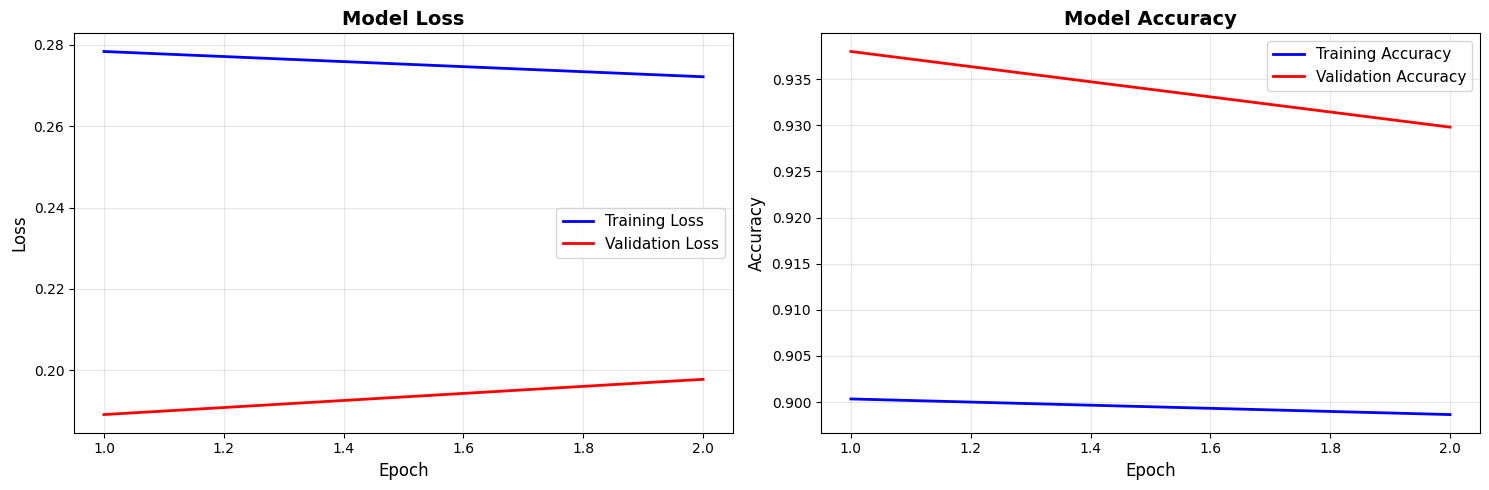

In [30]:
helper_utils.visualize_training_history(history_conv)
plt.show()

**Quick Check**: Visualize predictions

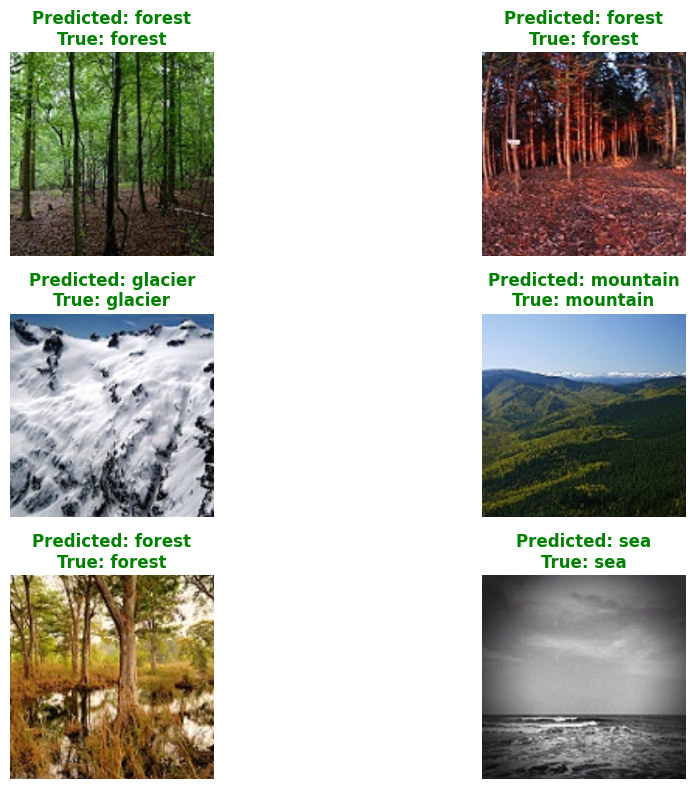

In [31]:
helper_utils.visualize_predictions(
    model,
    val_loader,
    class_names,
    device,
    num_images=6
)
plt.show()

<a name='4-2'></a>
### 4.2 Fine-tuning the ConvNet

In this approach, we unfreeze all layers and train the entire network with a smaller learning rate.

**Task:**

1. Load a fresh pre-trained model
2. Modify the final layer
3. Set up optimizer for all parameters with a smaller learning rate
4. Train the model

In [32]:
import torch
import torch.nn as nn
from torchvision import models

num_classes = 6

weights = models.ResNet18_Weights.DEFAULT
model_ft = models.resnet18(weights=weights)


model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)

model_ft = model_ft.to(device)
print("Fine-tuning model ready. fc =", model_ft.fc)


Fine-tuning model ready. fc = Linear(in_features=512, out_features=6, bias=True)


In [33]:
for param in model_ft.parameters():
    param.requires_grad = True

print("All layers unfrozen:", all(p.requires_grad for p in model_ft.parameters()))


All layers unfrozen: True


In [34]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.Adam(
    model_ft.parameters(),   # كل البراميترز
    lr=1e-4                  # LR أصغر للفاين تيوننغ
)

print("Optimizer set. LR = 1e-4")


Optimizer set. LR = 1e-4


In [35]:
history_ft = fit(
    model_ft,
    train_loader,
    val_loader,
    criterion,
    optimizer_ft,
    device,
    epochs=2
)

Epoch 1/2 | train_loss=0.4343 train_acc=0.8441 | val_loss=0.2431 val_acc=0.9084
Epoch 2/2 | train_loss=0.3272 train_acc=0.8787 | val_loss=0.2664 val_acc=0.8988


**Quick Check**: Visualize training history

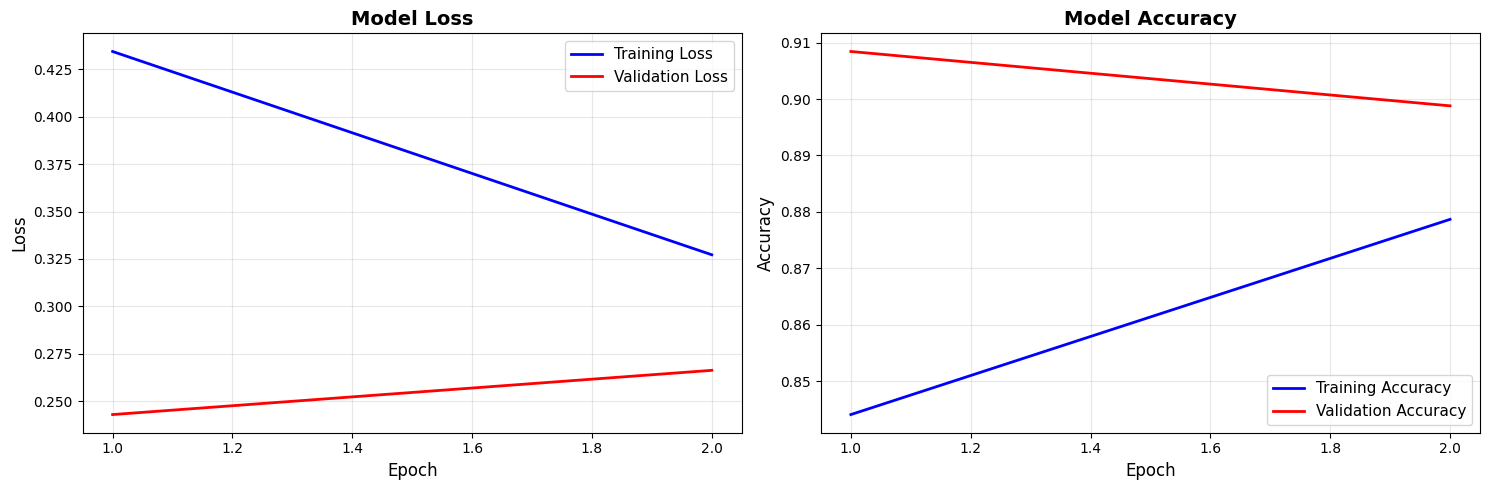

In [42]:
helper_utils.visualize_training_history(history_ft)
plt.show()

**Quick Check**: Visualize predictions

In [43]:
helper_utils.visualize_predictions(model_ft, dataloaders['val'], class_names, device, num_images=6)
plt.show()

NameError: name 'dataloaders' is not defined

<a name='5'></a>
## 5. Evaluation

Compare the performance of both approaches.

**Task:** Evaluate both models and compare their performance metrics.

In [38]:
# Evaluate models on validation set
# YOUR CODE HERE
# Compare final validation accuracies, training times, etc.

# Print comparison
# print("Feature Extractor Approach:")
# print(f"  Best Val Accuracy: {max(history_conv['val_acc']):.4f}")
# print(f"  Final Val Accuracy: {history_conv['val_acc'][-1]:.4f}")
# print()
# print("Fine-tuning Approach:")
# print(f"  Best Val Accuracy: {max(history_ft['val_acc']):.4f}")
# print(f"  Final Val Accuracy: {history_ft['val_acc'][-1]:.4f}")

<a name='6'></a>
## 6. Inference on Custom Images

Test your trained model on custom images.

**Task:** Load a custom image, preprocess it, and make a prediction using your trained model.

**Reference:** [Image Preprocessing](https://pytorch.org/vision/stable/transforms.html)

In [39]:
# Make prediction on a custom image
# img_path = 'path/to/your/image.jpg'

# YOUR CODE HERE
# Use helper_utils.visualize_single_prediction or helper_utils.predict_single_image
# helper_utils.visualize_single_prediction(
#     model_ft,  # or model_conv
#     img_path,
#     data_transforms['val'],
#     class_names,
#     device
# )
# plt.show()

# 🏆🎉 Congratulations on completing the Weekly Final Project! 🎉🏆

Fantastic job on finishing the Weekly Final Project! You’ve put your skills to the test and made it to the end. Take a moment to celebrate your hard work and dedication. Keep up the great work and continue your learning journey!

<a name='7'></a>
## 7. Deployment (ONNX)

Convert your trained model to ONNX format for deployment.

**Task:**
1. Convert the PyTorch model to ONNX format
2. Load the ONNX model and perform inference

**Reference:**
- [PyTorch to ONNX](https://docs.pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html)

In [40]:
# Convert model to ONNX
# YOUR CODE HERE

# Set model to evaluation mode
# model_ft.eval()

# Create dummy input (batch_size=1, channels=3, height=224, width=224)
# dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
# onnx_path = 'model.onnx'
# torch.onnx.export(
#     model_ft,
#     dummy_input,
#     onnx_path,
#     input_names=['input'],
#     output_names=['output'],
#     dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
# )

# print(f"Model exported to {onnx_path}")

In [41]:
# Load ONNX model and perform inference
# YOUR CODE HERE

# Load ONNX model
# ort_session = ort.InferenceSession(onnx_path)

# Prepare input (use validation transform)
# img_path = 'path/to/test/image.jpg'
# img = Image.open(img_path).convert('RGB')
# img_tensor = data_transforms['val'](img).unsqueeze(0)
# img_numpy = img_tensor.numpy()

# Run inference
# outputs = ort_session.run(None, {'input': img_numpy})
# predictions = np.array(outputs[0])
# pred_class_idx = np.argmax(predictions[0])
# pred_class = class_names[pred_class_idx]
# confidence = np.max(predictions[0])

# print(f"Predicted: {pred_class} (confidence: {confidence:.2%})")